<a href="https://colab.research.google.com/github/Arvinth-s/Dark-Sight/blob/master/DFT_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#OM NAMO NARAYANA

In [2]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os
from google.colab import drive
import torch
from IPython.display import clear_output

In [3]:
drive.flush_and_unmount()
drive.mount('/content/drive')
dsdir='/content/drive/My Drive/Dataset/'
sampledir = '/content/drive/My Drive/Dataset/sampleDataset'
f = open(dsdir+'DFT-CNN_Analysis/logs.txt', 'w')
f.write('successfully mounted drive\n')

Mounted at /content/drive


27

In [4]:
import shutil
dataset_dir = '/content/drive/My Drive/Dataset/Dataset/'
os.chdir(dsdir)
!ls
os.chdir(dataset_dir)
f.write('Dataset exists\n')

Dataset		  files_gen.py	  myFile_raw_jpg.txt  sampleDatasetlogs.txt
DFT_Analysis	  logs.txt	  myFile_raw.txt
DFT-CNN_Analysis  myFile_jpg.txt  sampleDataset


15

In [5]:
subdirs=[]
f.write('Dataset extracted\n')
for path, sd, files in os.walk(dataset_dir):
    if(sd != []):
      subdirs.append(sd)
subdirs=subdirs[0]
A=[]
for subdir in subdirs:
  a = list(os.listdir(subdir))
  a.sort()
  if(len(a)==10):
    a.append(subdir)
    A.append(a)
A = np.array(A)
longExposure=[]
shortExposure=[]
temperature=[]
longExposure = [dataset_dir + a[10] + "/" + a[4] for a in A]
shortExposure =[dataset_dir + a[10] + "/" +a[5] for a in A]
temperature = [dataset_dir + a[10] + "/" +a[6] for a in A]
f.write('Dataset extracted\n')

18

In [6]:
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from PIL import Image

In [24]:
def myVisualize(img):
  fig, a = plt.subplots(1, 2,figsize=(15,15))
  fig.suptitle('sample data point')
  for i in range(2):
    a[i].imshow(np.transpose(np.array(img[i]), (1, 2, 0)))

In [8]:
class Dplot():
  def __init__(self):
    self.fig = plt.figure(1)
    self.x = []
    self.y = []
    self.count = 0
  def update(self, data):
    self.count = self.count+1
    self.x.append(self.count)
    self.y.append(data)
    clear_output()
    if(self.count < 2):
      return
    plt.plot(self.x, self.y)
    plt.show()
  # def __call__(self, data):
  #   update(data)

In [9]:
import torchvision.transforms as T
class myTransform():
  class Resize():
    def __init__(self, size=512, interpolation=Image.BILINEAR):
      self.interpolation=interpolation
      self.size=size
    def __call__(self, img):
      old_size = img.size
      # print(old_size)
      ratio = float(self.size)/max(old_size)
      new_size = tuple([int(x * ratio) for x in old_size])
      return (img.resize(new_size, resample=self.interpolation))
  class myDFT():
    def __init__(self, interpolation=Image.BILINEAR):
      None
    def __call__(self, img):
      img = np.fft.fft2(img)
      return img
  class deBug():
    def __init__(self):
      None
    def __call__(self, img):
      return img
  class myNormalize():
    def __init___(self):
      None
    def __call__(self, img):
      img = T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))(img)
      return img


In [10]:
def FTransforms(train=True):
    trans = []
    trans.append(T.ToPILImage())
    trans.append(myTransform.deBug())
    # trans.append(myTransform.Resize())
    trans.append(T.CenterCrop(256))
    # trans.append(myTransform.myDFT())
    if(train==True):
      trans.append(T.RandomHorizontalFlip(p=0.5))
    trans.append(T.ToTensor())
    #mean and std=0.5
    # trans.append(myTransform.myNormalize())
    return T.Compose(trans)

In [11]:
class ImageDataset():
    def __init__(self, image_list, transforms=None):
        self.image_list = image_list
        self.transforms = transforms
         
    def __len__(self):
        print(len(self.image_list[0]))
        return (len(self.image_list[0]))

    
    def __getitem__(self, i):
        image = []
        image = [plt.imread(self.image_list[j][i]) for j in range(2)]
        image = [Image.fromarray(img).convert('RGB')  for img in image]
        image = [np.asarray(img).astype(np.uint8) for img in image]
        # print('image shape', np.array(image).shape)
        if self.transforms is not None:
            image = [self.transforms(img) for img in image]
        image = np.array([img.numpy() for img in image])
        return (torch.tensor(image[0], dtype=torch.float), torch.tensor(image[1], dtype=torch.float))

In [12]:
image_list = [longExposure, shortExposure, temperature]
data_set = ImageDataset(image_list=image_list, transforms = FTransforms(train = False))
data = DataLoader(data_set, batch_size=4)
idata = iter(data)
ndata = next(idata)
print(type(ndata))
print(np.array(ndata[1]).shape)
print(len(ndata))
# print(type(data[0]))
# myVisualize(data[0])


145
<class 'list'>
(4, 3, 256, 256)
2


In [13]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

In [14]:
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import DataLoader

[reference](https://github.com/milesial/Pytorch-UNet/)

In [15]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        self.in_channels=in_channels
        self.out_channels=out_channels
        if not mid_channels:
            mid_channels = out_channels
        self.mid_channels=mid_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)


    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [16]:
class UNet(nn.Module):
    def __init__(self, n_channels=3, n_classes=3, bilinear=True):
        super().__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear
        self.figure = Dplot()

        self.inc = DoubleConv(n_channels, out_channels=64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)
        # self.model = None

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        # print(x5.shape)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)
        # self.model = x
        return x
    def Train(self, data_loader, optimizer, epochs, criterion):
      data = iter(data_loader)
      for epoch in range(epochs):
        eloss = 0
        data_img = next(data)
        input = data_img[0]
        output = data_img[1]
        pred = self.forward(input)
        loss = criterion(pred, output)
        eloss = loss.item()
        (self.figure).update(eloss)
        print('epoch: {} loss: {:.2f}'.format(epoch+1, eloss))

        optimizer.zero_grad()

        loss.backward()
        optimizer.step()

        

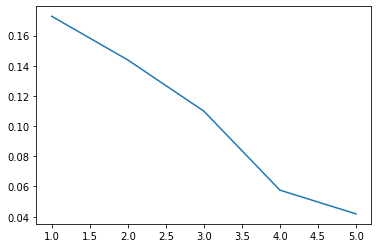

epoch: 5 loss: 0.04


In [25]:
model = UNet(n_channels=3)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()
image_list = [longExposure, shortExposure, temperature]
data_set = ImageDataset(image_list=image_list, transforms = FTransforms(train = False))
data_loader = DataLoader(data_set, batch_size = 5)
model.Train(data_loader, optimizer, 5, criterion)

145


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


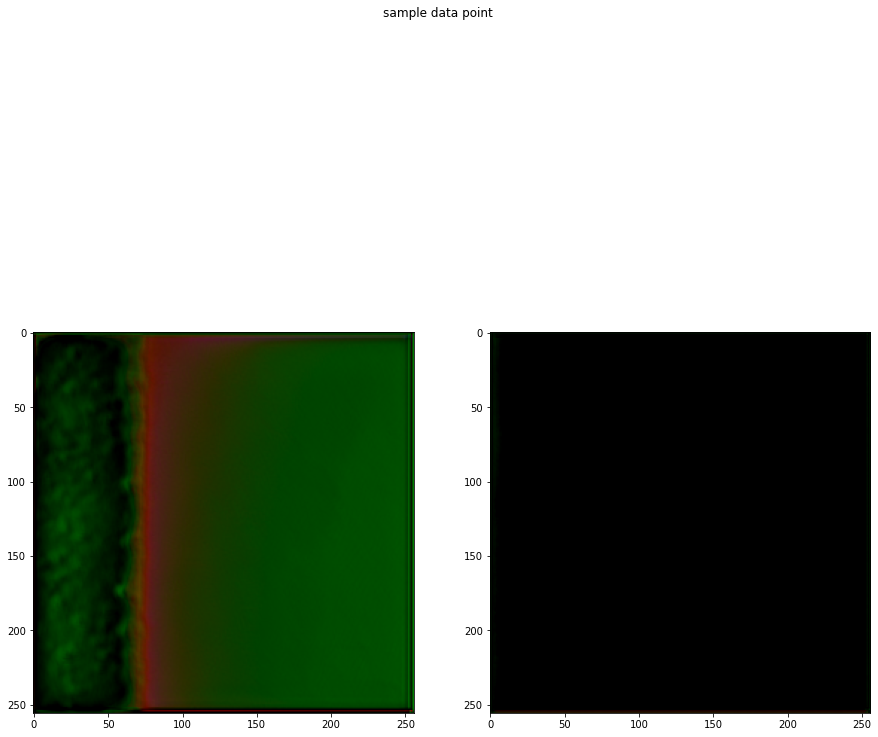

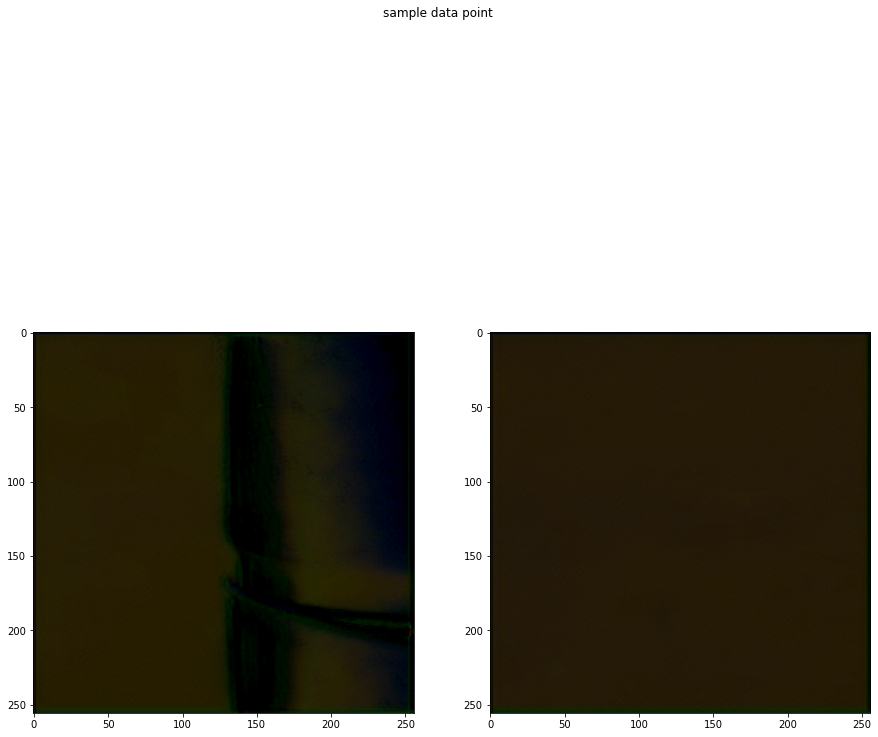

In [26]:
itr = iter(data_loader)
data_img = next(itr)
input = data_img[0]
output = data_img[1]
pred = model.forward(input).detach()
myVisualize([pred[0], pred[1]])
data_img = next(itr)
input = data_img[0]
output = data_img[1]
pred = model.forward(input).detach()
myVisualize([pred[0], pred[1]])

In [ ]:
acriterion =nn. MSELoss()
optimizer = optim.Adam(myModel.parameters(), lr=0.1)
for i in range(10):
  loss = criterion(myModel(data[0]), data[1])
  optimizer.zero_grad()
  loss.backward()
  losses = loss.item()
  print('epoch:{} error:{}'.format(i+1, losses))
  optimizer.step()

In [ ]:
pred = myModel(data[0])
prediction = pred.detach()
prediction = [np.fft.ifft2(np.array(Pred)).astype(np.uint8) for Pred in prediction]
myVisualize(prediction)